# Anatomy of a GPT

*An investigation into the internal states of the model. Spoiler: The only thing falling here is the loss curve*

![Anatomy of a GPT](../assets/anatomy-of-a-gpt.jpg)

We start by loading the base `config.json`

In [1]:
import json
import types

with open("../config.json") as fd:
    config = json.load(fd, object_hook=lambda d: types.SimpleNamespace(**d))
config

namespace(hidden_size=256,
          intermediate_size=1024,
          num_hidden_layers=4,
          max_position_embeddings=1024,
          tie_word_embeddings=True,
          num_attention_heads=4,
          num_key_value_heads=2,
          head_dim=64,
          dropout_p=0.1,
          seed=1728,
          vocab_size=8192,
          special_tokens=['<|startoftext|>', '<|endoftext|>'],
          batch_size=16,
          block_size=512,
          learning_rate=0.0005,
          eval_iters=50,
          eval_interval=500,
          max_iters=35000,
          temperature=0.7)

We perform basic checks to ensure the configuration is valid

In [2]:
assert config.intermediate_size == 4 * config.hidden_size
assert config.num_attention_heads % config.num_key_value_heads == 0
assert config.num_attention_heads * config.head_dim == config.hidden_size
assert config.max_position_embeddings >= config.block_size

We then load the model and check its internals

In [3]:
import sys

sys.path.append("../src")
import model

import torch
import torchinfo

device = "cuda" if torch.cuda.is_available() else "cpu"

m = model.Transformer(config).to(device)
torchinfo.summary(
    m,
    input_size=(config.batch_size, config.max_position_embeddings),
    dtypes=[torch.long],
)

Layer (type:depth-idx)                        Output Shape              Param #
Transformer                                   [16, 1024, 8192]          --
├─Embedding: 1-1                              [16, 1024, 256]           2,097,152
├─Embedding: 1-2                              [1024, 256]               262,144
├─Dropout: 1-3                                [16, 1024, 256]           --
├─ModuleList: 1-4                             --                        --
│    └─DecoderLayer: 2-1                      [16, 1024, 256]           --
│    │    └─RMSNorm: 3-1                      [16, 1024, 256]           256
│    │    └─GroupedQueryAttention: 3-2        [16, 1024, 256]           196,608
│    │    └─RMSNorm: 3-3                      [16, 1024, 256]           256
│    │    └─FeedForward: 3-4                  [16, 1024, 256]           524,288
│    └─DecoderLayer: 2-2                      [16, 1024, 256]           --
│    │    └─RMSNorm: 3-5                      [16, 1024, 256]          

We will now run a quick test to see if everything works as inteded

In [4]:
import math

optimizer = torch.optim.AdamW(m.parameters(), lr=config.learning_rate)

x = torch.arange(8).view(1, -1).to(device)
y = torch.arange(1, 8 + 1).view(1, -1).to(device)

print(f"Expected initial loss: {math.log(config.vocab_size)}")

for i in range(100):
    logits, loss = m(x, labels=y)
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(f"Step {i:3}: loss = {loss.item():.4f}")

print(f"Final loss = {loss.item():.4f}")

Expected initial loss: 9.010913347279288
Step   0: loss = 9.1844
Step  10: loss = 4.5320
Step  20: loss = 2.6095
Step  30: loss = 1.2470
Step  40: loss = 0.4560
Step  50: loss = 0.0783
Step  60: loss = 0.0513
Step  70: loss = 0.0121
Step  80: loss = 0.0045
Step  90: loss = 0.0600
Final loss = 0.2762


We now load the *training data* and *validation data*. Both are generated by running `python data/prepare.py` in the root directory

In [5]:
train_data = torch.load("../data/train_data.bin").to(device)
val_data = torch.load("../data/val_data.bin").to(device)

We create a brand-new transformer with fresh weights

In [6]:
del m
m = model.Transformer(config).to(device)

Now, we get ready for the real training!

In [7]:
def get_batch(mode, block_size):
    data = train_data if mode == "train" else val_data
    N = data.size(0)
    start = torch.randint(
        0,
        N - block_size - 1,
        (config.batch_size,),
        device=data.device,
    )
    pos = start[:, None] + torch.arange(block_size, device=data.device)[None, :]
    return data[pos], data[pos + 1]


@torch.no_grad()
def estimate_loss(block_size):
    losses = {}
    m.eval()
    for mode in ["train", "val"]:
        total = 0.0
        for _ in range(config.eval_iters):
            x, y = get_batch(mode, block_size)
            _, loss = m(x, labels=y)
            total += loss.item()
        losses[mode] = total / config.eval_iters
    m.train()
    return losses

In [8]:
import transformers


optimizer = torch.optim.AdamW(m.parameters(), lr=config.learning_rate)
scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(config.max_iters * 0.05),
    num_training_steps=config.max_iters,
)

This is the main training loop

In [9]:
import tqdm

tokens = torch.zeros(config.max_iters, dtype=torch.float)
losses = torch.zeros(config.max_iters, dtype=torch.float)

tokens_seen = 0

print(f"Expected initial loss: {math.log(config.vocab_size)}")
m.train()

block_size = config.block_size

for i in tqdm.tqdm(range(config.max_iters)):
    if i == 28000:
        block_size = 2 * config.block_size
        for pg in optimizer.param_groups:
            pg["lr"] = 3e-4
        scheduler = transformers.get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int((config.max_iters - 28000) * 0.05),
            num_training_steps=config.max_iters - 28000,
        )
    x, y = get_batch("train", block_size)

    tokens_seen += x.numel()
    tokens[i] = tokens_seen

    _, loss = m(x, labels=y)
    losses[i] = loss.item()

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(m.parameters(), 1.0)

    optimizer.step()
    scheduler.step()

    if i % config.eval_interval == 0 and i > 0:
        eval = estimate_loss(block_size)
        print(
            f'Step {i}: training loss = {eval["train"]:.4f}, validation loss = {eval["val"]:.4f}'
        )
        print(f"  -> Current learning rate: {scheduler.get_last_lr()[0]:.2e}")

eval = estimate_loss(block_size)
print(
    f'Post-training: training loss = {eval["train"]:.4f}, validation loss = {eval["val"]:.4f}'
)
print(f"  -> Final learning rate: {scheduler.get_last_lr()[0]:.2e}")

print("Done!")

num_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
torch.save(
    m.state_dict(), f"../data/nlab-gpt-{num_params // 1_000_000}M-{config.max_iters}.pt"
)

Expected initial loss: 9.010913347279288


  1%|▏         | 505/35000 [00:24<1:23:43,  6.87it/s]

Step 500: training loss = 5.3655, validation loss = 5.3537
  -> Current learning rate: 1.43e-04


  3%|▎         | 1003/35000 [00:47<1:46:36,  5.32it/s]

Step 1000: training loss = 4.3556, validation loss = 4.3878
  -> Current learning rate: 2.86e-04


  4%|▍         | 1504/35000 [01:11<1:21:48,  6.82it/s]

Step 1500: training loss = 3.8138, validation loss = 3.8230
  -> Current learning rate: 4.29e-04


  6%|▌         | 2005/35000 [01:35<1:20:12,  6.86it/s]

Step 2000: training loss = 3.4440, validation loss = 3.4819
  -> Current learning rate: 5.00e-04


  7%|▋         | 2503/35000 [01:59<1:42:56,  5.26it/s]

Step 2500: training loss = 3.1855, validation loss = 3.2706
  -> Current learning rate: 4.99e-04


  9%|▊         | 3004/35000 [02:23<1:17:54,  6.85it/s]

Step 3000: training loss = 2.9981, validation loss = 3.1008
  -> Current learning rate: 4.98e-04


 10%|█         | 3505/35000 [02:47<1:16:46,  6.84it/s]

Step 3500: training loss = 2.8720, validation loss = 2.9748
  -> Current learning rate: 4.97e-04


 11%|█▏        | 4003/35000 [03:11<1:38:11,  5.26it/s]

Step 4000: training loss = 2.7473, validation loss = 2.8501
  -> Current learning rate: 4.94e-04


 13%|█▎        | 4504/35000 [03:34<1:14:32,  6.82it/s]

Step 4500: training loss = 2.6684, validation loss = 2.7805
  -> Current learning rate: 4.92e-04


 14%|█▍        | 5005/35000 [03:58<1:13:32,  6.80it/s]

Step 5000: training loss = 2.5866, validation loss = 2.6775
  -> Current learning rate: 4.88e-04


 16%|█▌        | 5503/35000 [04:22<1:33:49,  5.24it/s]

Step 5500: training loss = 2.5300, validation loss = 2.6066
  -> Current learning rate: 4.84e-04


 17%|█▋        | 6004/35000 [04:46<1:10:51,  6.82it/s]

Step 6000: training loss = 2.5235, validation loss = 2.5696
  -> Current learning rate: 4.80e-04


 19%|█▊        | 6505/35000 [05:10<1:09:38,  6.82it/s]

Step 6500: training loss = 2.4968, validation loss = 2.5172
  -> Current learning rate: 4.75e-04


 20%|██        | 7003/35000 [05:34<1:28:49,  5.25it/s]

Step 7000: training loss = 2.4258, validation loss = 2.4802
  -> Current learning rate: 4.70e-04


 21%|██▏       | 7504/35000 [05:58<1:07:17,  6.81it/s]

Step 7500: training loss = 2.4139, validation loss = 2.4999
  -> Current learning rate: 4.64e-04


 23%|██▎       | 8005/35000 [06:22<1:06:20,  6.78it/s]

Step 8000: training loss = 2.3936, validation loss = 2.4647
  -> Current learning rate: 4.58e-04


 24%|██▍       | 8503/35000 [06:46<1:24:06,  5.25it/s]

Step 8500: training loss = 2.3503, validation loss = 2.4457
  -> Current learning rate: 4.51e-04


 26%|██▌       | 9004/35000 [07:10<1:03:26,  6.83it/s]

Step 9000: training loss = 2.3272, validation loss = 2.3819
  -> Current learning rate: 4.44e-04


 27%|██▋       | 9505/35000 [07:34<1:02:09,  6.84it/s]

Step 9500: training loss = 2.2783, validation loss = 2.3936
  -> Current learning rate: 4.36e-04


 29%|██▊       | 10003/35000 [07:58<1:19:16,  5.26it/s]

Step 10000: training loss = 2.3028, validation loss = 2.3853
  -> Current learning rate: 4.28e-04


 30%|███       | 10504/35000 [08:22<59:47,  6.83it/s]  

Step 10500: training loss = 2.3058, validation loss = 2.3084
  -> Current learning rate: 4.19e-04


 31%|███▏      | 11005/35000 [08:46<58:35,  6.83it/s]  

Step 11000: training loss = 2.2672, validation loss = 2.3477
  -> Current learning rate: 4.10e-04


 33%|███▎      | 11503/35000 [09:10<1:14:27,  5.26it/s]

Step 11500: training loss = 2.2527, validation loss = 2.3353
  -> Current learning rate: 4.01e-04


 34%|███▍      | 12004/35000 [09:34<56:17,  6.81it/s]  

Step 12000: training loss = 2.2408, validation loss = 2.3539
  -> Current learning rate: 3.92e-04


 36%|███▌      | 12505/35000 [09:58<55:04,  6.81it/s]  

Step 12500: training loss = 2.2422, validation loss = 2.3237
  -> Current learning rate: 3.82e-04


 37%|███▋      | 13003/35000 [10:21<1:09:56,  5.24it/s]

Step 13000: training loss = 2.2252, validation loss = 2.3002
  -> Current learning rate: 3.72e-04


 39%|███▊      | 13504/35000 [10:46<52:31,  6.82it/s]  

Step 13500: training loss = 2.1924, validation loss = 2.2749
  -> Current learning rate: 3.61e-04


 40%|████      | 14004/35000 [11:10<51:22,  6.81it/s]  

Step 14000: training loss = 2.2062, validation loss = 2.2683
  -> Current learning rate: 3.50e-04


 41%|████▏     | 14505/35000 [11:34<50:07,  6.81it/s]  

Step 14500: training loss = 2.1692, validation loss = 2.2820
  -> Current learning rate: 3.39e-04


 43%|████▎     | 15003/35000 [11:57<1:03:34,  5.24it/s]

Step 15000: training loss = 2.1456, validation loss = 2.3074
  -> Current learning rate: 3.28e-04


 44%|████▍     | 15504/35000 [12:21<47:38,  6.82it/s]  

Step 15500: training loss = 2.1422, validation loss = 2.3096
  -> Current learning rate: 3.17e-04


 46%|████▌     | 16004/35000 [12:45<50:14,  6.30it/s]

Step 16000: training loss = 2.1577, validation loss = 2.2695
  -> Current learning rate: 3.06e-04


 47%|████▋     | 16505/35000 [13:09<45:06,  6.83it/s]

Step 16500: training loss = 2.1375, validation loss = 2.2147
  -> Current learning rate: 2.94e-04


 49%|████▊     | 17003/35000 [13:33<57:05,  5.25it/s]

Step 17000: training loss = 2.1557, validation loss = 2.2392
  -> Current learning rate: 2.82e-04


 50%|█████     | 17504/35000 [13:57<42:38,  6.84it/s]

Step 17500: training loss = 2.1207, validation loss = 2.2219
  -> Current learning rate: 2.71e-04


 51%|█████▏    | 18005/35000 [14:21<41:29,  6.83it/s]

Step 18000: training loss = 2.1831, validation loss = 2.2711
  -> Current learning rate: 2.59e-04


 53%|█████▎    | 18503/35000 [14:45<52:20,  5.25it/s]

Step 18500: training loss = 2.1013, validation loss = 2.2413
  -> Current learning rate: 2.47e-04


 54%|█████▍    | 19004/35000 [15:09<38:57,  6.84it/s]

Step 19000: training loss = 2.0716, validation loss = 2.2128
  -> Current learning rate: 2.35e-04


 56%|█████▌    | 19505/35000 [15:33<37:52,  6.82it/s]

Step 19500: training loss = 2.1187, validation loss = 2.2406
  -> Current learning rate: 2.23e-04


 57%|█████▋    | 20003/35000 [15:57<47:48,  5.23it/s]

Step 20000: training loss = 2.1193, validation loss = 2.2051
  -> Current learning rate: 2.12e-04


 59%|█████▊    | 20504/35000 [16:21<35:26,  6.82it/s]

Step 20500: training loss = 2.0901, validation loss = 2.1758
  -> Current learning rate: 2.00e-04


 60%|██████    | 21005/35000 [16:45<34:15,  6.81it/s]

Step 21000: training loss = 2.0716, validation loss = 2.2268
  -> Current learning rate: 1.89e-04


 61%|██████▏   | 21503/35000 [17:09<42:48,  5.25it/s]

Step 21500: training loss = 2.0658, validation loss = 2.1961
  -> Current learning rate: 1.77e-04


 63%|██████▎   | 22004/35000 [17:33<31:37,  6.85it/s]

Step 22000: training loss = 2.0649, validation loss = 2.1741
  -> Current learning rate: 1.66e-04


 64%|██████▍   | 22505/35000 [17:57<30:32,  6.82it/s]

Step 22500: training loss = 2.0321, validation loss = 2.1572
  -> Current learning rate: 1.55e-04


 66%|██████▌   | 23003/35000 [18:21<38:12,  5.23it/s]

Step 23000: training loss = 2.0450, validation loss = 2.1280
  -> Current learning rate: 1.44e-04


 67%|██████▋   | 23504/35000 [18:45<28:06,  6.82it/s]

Step 23500: training loss = 2.0433, validation loss = 2.1500
  -> Current learning rate: 1.34e-04


 69%|██████▊   | 24005/35000 [19:09<26:54,  6.81it/s]

Step 24000: training loss = 2.0577, validation loss = 2.1480
  -> Current learning rate: 1.23e-04


 70%|███████   | 24503/35000 [19:33<33:21,  5.24it/s]

Step 24500: training loss = 2.0486, validation loss = 2.1808
  -> Current learning rate: 1.13e-04


 71%|███████▏  | 25004/35000 [19:57<24:26,  6.81it/s]

Step 25000: training loss = 2.0056, validation loss = 2.1589
  -> Current learning rate: 1.04e-04


 73%|███████▎  | 25505/35000 [20:20<23:12,  6.82it/s]

Step 25500: training loss = 2.0285, validation loss = 2.1746
  -> Current learning rate: 9.41e-05


 74%|███████▍  | 26003/35000 [20:44<28:31,  5.26it/s]

Step 26000: training loss = 2.0184, validation loss = 2.1813
  -> Current learning rate: 8.51e-05


 76%|███████▌  | 26504/35000 [21:08<20:42,  6.84it/s]

Step 26500: training loss = 1.9836, validation loss = 2.1757
  -> Current learning rate: 7.64e-05


 77%|███████▋  | 27005/35000 [21:32<19:30,  6.83it/s]

Step 27000: training loss = 2.0400, validation loss = 2.1773
  -> Current learning rate: 6.81e-05


 79%|███████▊  | 27503/35000 [21:56<23:56,  5.22it/s]

Step 27500: training loss = 2.0111, validation loss = 2.1332
  -> Current learning rate: 6.02e-05


 80%|████████  | 28003/35000 [22:23<42:11,  2.76it/s]

Step 28000: training loss = 3.1205, validation loss = 3.1964
  -> Current learning rate: 1.43e-06


 81%|████████▏ | 28503/35000 [23:25<1:19:26,  1.36it/s]

Step 28500: training loss = 2.0692, validation loss = 2.1573
  -> Current learning rate: 4.99e-04


 83%|████████▎ | 29003/35000 [24:27<1:13:31,  1.36it/s]

Step 29000: training loss = 2.0481, validation loss = 2.1878
  -> Current learning rate: 4.88e-04


 84%|████████▍ | 29503/35000 [25:30<1:07:21,  1.36it/s]

Step 29500: training loss = 2.0180, validation loss = 2.1868
  -> Current learning rate: 4.64e-04


 86%|████████▌ | 30003/35000 [26:32<1:01:17,  1.36it/s]

Step 30000: training loss = 2.0520, validation loss = 2.1502
  -> Current learning rate: 4.28e-04


 87%|████████▋ | 30503/35000 [27:35<55:08,  1.36it/s]  

Step 30500: training loss = 1.9848, validation loss = 2.1289
  -> Current learning rate: 3.82e-04


 89%|████████▊ | 31003/35000 [28:37<48:57,  1.36it/s]  

Step 31000: training loss = 2.0026, validation loss = 2.1262
  -> Current learning rate: 3.28e-04


 90%|█████████ | 31503/35000 [29:39<42:53,  1.36it/s]  

Step 31500: training loss = 2.0237, validation loss = 2.1201
  -> Current learning rate: 2.71e-04


 91%|█████████▏| 32003/35000 [30:42<36:46,  1.36it/s]  

Step 32000: training loss = 1.9894, validation loss = 2.0807
  -> Current learning rate: 2.12e-04


 93%|█████████▎| 32503/35000 [31:44<30:37,  1.36it/s]

Step 32500: training loss = 1.9303, validation loss = 2.1225
  -> Current learning rate: 1.55e-04


 94%|█████████▍| 33003/35000 [32:47<24:28,  1.36it/s]

Step 33000: training loss = 1.9593, validation loss = 2.0852
  -> Current learning rate: 1.03e-04


 96%|█████████▌| 33503/35000 [33:49<18:21,  1.36it/s]

Step 33500: training loss = 1.9467, validation loss = 2.0558
  -> Current learning rate: 6.01e-05


 97%|█████████▋| 34003/35000 [34:51<12:13,  1.36it/s]

Step 34000: training loss = 1.9733, validation loss = 2.0670
  -> Current learning rate: 2.73e-05


 99%|█████████▊| 34503/35000 [35:54<06:05,  1.36it/s]

Step 34500: training loss = 1.9357, validation loss = 2.0617
  -> Current learning rate: 6.91e-06


100%|██████████| 35000/35000 [36:52<00:00, 15.82it/s]


Post-training: training loss = 1.9693, validation loss = 2.0863
  -> Final learning rate: 0.00e+00
Done!


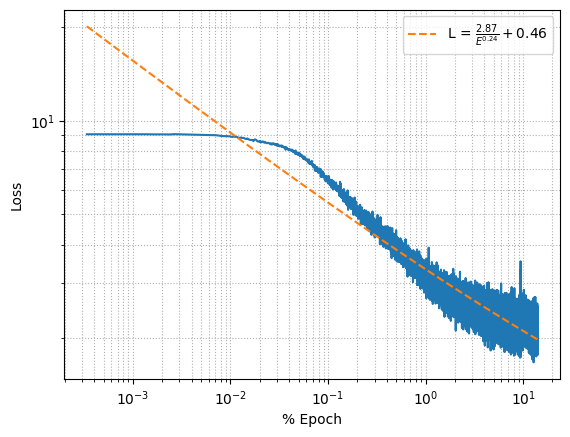

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import scipy


def power_law(x, a, b, c):
    return a * np.power(x, -b) + c


epochs = tokens.numpy() / train_data.numel()
losses = losses.numpy()

params, _ = scipy.optimize.curve_fit(
    power_law, xdata=epochs, ydata=losses, p0=[1.0, 1.0, 1.0]
)
a, b, c = params

plt.loglog(epochs, losses)
plt.loglog(
    epochs,
    power_law(epochs, a, b, c),
    linestyle="--",
    label="L = $\\frac{" f"{a:.2f}" "}{E^{" f"{b:.2f}" "}} " f"{c:+.2f}$",
)
plt.grid(which="both", linestyle="dotted")
plt.legend()
plt.xlabel("%" " Epoch")
plt.ylabel("Loss")
plt.show()

We now load the tokenizer generated with `data/prepare.py` before

In [11]:
import tokenizers

tokenizer = tokenizers.Tokenizer.from_file("../data/tokenizer.json")

... And we can finally try generating text, one token at a time!

In [ ]:
for token in m.generate(
    torch.tensor([tokenizer.encode("<|startoftext|>").ids], device=device),
    256,
    temperature=2,
    top_k=50,
):
    token = tokenizer.decode(token[0].tolist())
    if token == "<|endoftext|>":
        break
    print(token, end="", flush=True)

}

+-- {: .rightHandSide}
+-- {: .toc .clickDown tabindex="0"}
####Context###
#### Algebra
+--{: .hide}

=--
=--
=--

#Contents#
* table of contents
{:toc}

## Idea

A _linear algebra_ is a linear algebra. 

## Definition

A _linear_ $A$ in 

1. a _linear linear algebra_ is a linear isomorphism of the form

1. a linear map (linear)

such that a linear map is linear, a linear map of linear operators (a linear map) and a linear map is a linear map

1. a linear map is a linear map over $V$.

To make this precise sense, we are looking on the linear map (in a linear map) to be written:

 \[
 \label{LinearLinearSpanier}
 \begin{array}{l}
 \mathllap{A \otimes A \otimes A \to A
 \mathrlap{\,.}
 \mathrlap{\,.}
 \mathrlap{\,.}
 \end{array}
 \]

Here:


1. a linear map is linear map,

1. a linear map in a linear way,

1. a linear map is bilinear map.

1. a linear map is linear.

1. a linear map is linear if,

1. a linear map is linear on a linear map.

1. a linear map is a linear map.

These are 